## Capstone Project - FML Spring 2023
## Helen Zhang (qz2086, N10155259)

In [44]:
import random
seed = 10155259
random.seed(seed)

In [45]:
# Import the necessary modules
import pandas as pd
import numpy as np
import torch
import random
from torch import nn, optim
from sklearn import model_selection
from sklearn import metrics, tree, ensemble, calibration
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import torch.nn.functional as nnfunctional
from scipy.special import softmax


music = pd.read_csv('musicData.csv', encoding = 'iso8859_1')
music = music.iloc[:, :18]
music.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,RÃ¶yksopp,RÃ¶yksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


### Data Cleaning

I noticed there are some rows that's shifted to the left, so i first moved them back.

In [46]:
missing = music.isna()
for index, row in music.iterrows():  
    if missing['music_genre'][index]:
        music.loc[index] = music.loc[index].shift(1)
music.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,RÃ¶yksopp,RÃ¶yksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [47]:
X_num = music[['acousticness','danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence']].astype('float64')
X_norm = (X_num - X_num.mean()) / X_num.std()
Y = music['music_genre'].astype('category')

In [48]:
# deal with incorrect values imputed: impute mean
# popularity: after shifting roles there's messy values from song name, replaced with mean 
popularity = music['popularity']
pop_mean = int(sum(pd.to_numeric(popularity, errors = 'coerce').dropna()) / len(pd.to_numeric(popularity, errors = 'coerce').dropna()))
popularity = pd.to_numeric(popularity, errors = 'coerce').fillna(pop_mean)

#duration: -1 swapped by mean
duration = music['duration_ms'].where(music['duration_ms'] != -1, np.nan)
duration_mean = int(sum(pd.to_numeric(duration, errors = 'coerce').dropna()) / len(pd.to_numeric(duration, errors = 'coerce').dropna()))
duration = pd.to_numeric(duration, errors = 'coerce').fillna(duration_mean)

# tempo: "?" swapped by mean
tempo = music['tempo'].replace('?', np.nan)
tempo_mean = int(sum(pd.to_numeric(tempo, errors = 'coerce').dropna()) / len(pd.to_numeric(tempo, errors = 'coerce').dropna()))
tempo = pd.to_numeric(tempo, errors = 'coerce').fillna(tempo_mean)

# put them altogether
modified = pd.concat([popularity, duration, tempo], axis = 1, join = 'inner')
modified = (modified - modified.mean()) / (modified.std())

# mode and key?
km = pd.get_dummies(music, columns = ['key', 'mode'])
km = km.iloc[:,16:]

# put all things together
music = pd.concat([X_norm, modified, km], axis = 1, join = 'inner')
total_frame = pd.concat([music, Y], axis = 1, join = 'inner')
total_frame.dropna(inplace=True)
total_frame.shape
Y = total_frame['music_genre']
X = total_frame.iloc[:, :25]
# X.drop("acousticness",inplace=True,axis=1)
X

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,popularity,duration_ms,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor
0,-0.883877,0.524873,1.289863,1.875791,-0.488109,0.638126,-0.185320,1.225061,-1.108046,-0.000005,...,0,0,0,0,0,0,0,0,0,1
1,-0.860382,0.356930,1.097090,2.361333,-0.432428,0.339245,-0.627251,0.302428,-0.850666,-0.257234,...,0,1,0,0,0,0,0,0,0,1
2,-0.888623,0.345734,0.586807,-0.521807,2.104119,0.732885,-0.582861,-0.498807,-1.043701,-0.282569,...,0,0,0,0,0,0,0,1,1,0
3,-0.823175,1.207841,0.378914,-0.550294,-0.228267,0.752194,1.434438,-0.753745,-0.657631,-0.743313,...,1,0,0,0,0,0,0,0,1,0
4,-0.883965,0.446499,-0.048211,2.235338,-0.228267,0.465320,-0.515782,-0.539273,-0.786321,-0.218702,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,-0.799738,1.985978,-0.097350,-0.558069,-0.463362,0.342652,2.016446,-0.510947,0.950993,-0.000005,...,1,0,0,0,0,0,0,0,1,0
50001,-0.437636,0.843965,-0.898683,-0.558069,-0.525229,-0.110375,-0.380638,-1.389067,1.787478,0.060091,...,0,0,0,0,0,0,0,0,1,0
50002,-0.880098,0.754395,0.617046,-0.558069,-0.314881,0.598859,0.517035,-0.247915,0.436233,-0.529589,...,0,1,0,0,0,0,0,0,1,0
50003,-0.654136,1.252626,-0.482897,-0.558069,-0.543789,0.668143,-0.488161,-0.413827,1.337063,0.163257,...,0,0,0,0,0,0,1,0,0,1


### Data Visualization

C:\Users\hp\AppData\Local\Temp\ipykernel_16520\3032900126.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X.hist(ax=ax, bins=20)


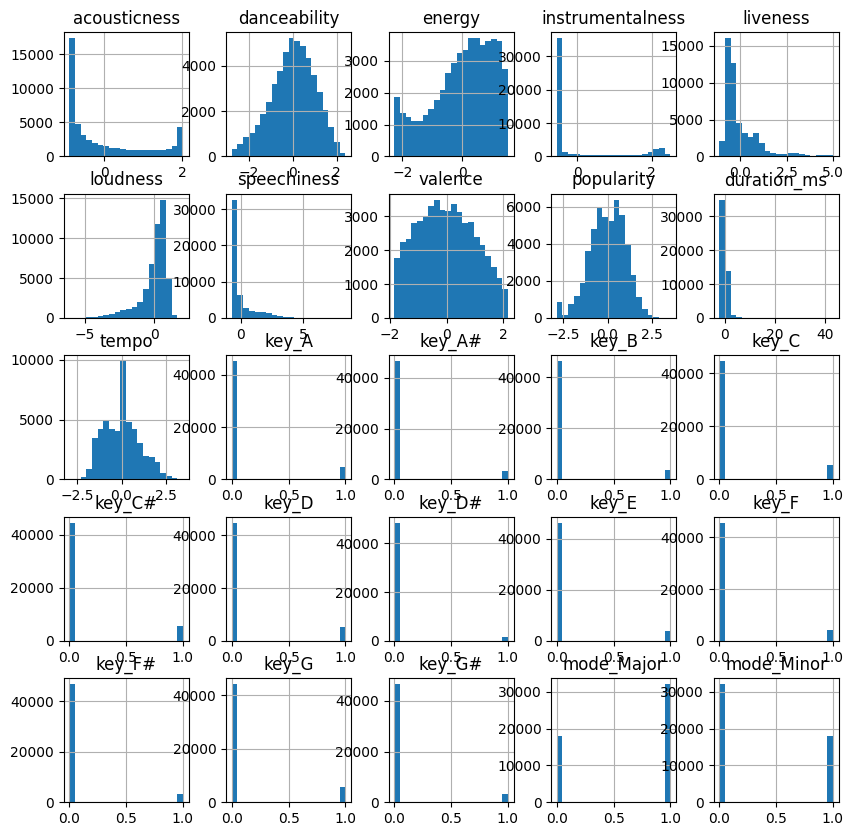

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
X.hist(ax=ax, bins=20)
plt.show()

In [50]:
for i in Y.cat.categories:
    print(i, sum(Y == i))

Alternative 5000
Anime 5000
Blues 5000
Classical 5000
Country 5000
Electronic 5000
Hip-Hop 5000
Jazz 5000
Rap 5000
Rock 5000


### PCA

In [51]:
pca_mdl = PCA().fit(X)
print("Eigenvalues: ",pca_mdl.explained_variance_)
print("percentage of variance explained: ", pca_mdl.explained_variance_ratio_)
counter = 0
for item in pca_mdl.explained_variance_:
    if item >1: counter += 1
print("Number of eigenvalues > 1 :", counter)

Eigenvalues:  [3.70640416e+00 1.34738517e+00 1.05584702e+00 9.76693886e-01
 9.47856845e-01 8.22864704e-01 7.40564691e-01 5.99894279e-01
 4.61569573e-01 4.45915725e-01 2.56933875e-01 1.13118692e-01
 1.12128840e-01 1.06627275e-01 1.05040649e-01 9.74231621e-02
 8.82665602e-02 7.93013976e-02 7.51088375e-02 6.96831546e-02
 6.53374388e-02 6.26769820e-02 3.32609021e-02 1.23023613e-31
 1.38022933e-32]
percentage of variance explained:  [2.99630798e-01 1.08924466e-01 8.53561221e-02 7.89572741e-02
 7.66260482e-02 6.65215119e-02 5.98682659e-02 4.84962768e-02
 3.73139177e-02 3.60484391e-02 2.07708871e-02 9.14467027e-03
 9.06464931e-03 8.61989528e-03 8.49163019e-03 7.87582212e-03
 7.13558985e-03 6.41083381e-03 6.07190150e-03 5.63328184e-03
 5.28196821e-03 5.06689324e-03 2.68885697e-03 9.94539768e-33
 1.11579633e-33]
Number of eigenvalues > 1 : 3


In [52]:
# Sort the eigenvalues and eigenvectors in descending order
eigenvalues = pca_mdl.explained_variance_
eigenvectors = pca_mdl.components_
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[idx]

# Get the names of the variables
variable_names = X.columns.values

# Print the names of the variables in the order of eigenvalues
for i in range(len(variable_names)):
    print(f"{variable_names[i]}: {eigenvalues[i]}")

acousticness: 3.7064041565825514
danceability: 1.347385169006011
energy: 1.0558470204099009
instrumentalness: 0.9766938864184483
liveness: 0.9478568454393359
loudness: 0.8228647037942977
speechiness: 0.7405646911561986
valence: 0.5998942788720611
popularity: 0.4615695726525709
duration_ms: 0.44591572451529765
tempo: 0.2569338752627865
key_A: 0.1131186916564971
key_A#: 0.11212884011282002
key_B: 0.10662727545357348
key_C: 0.10504064874025389
key_C#: 0.09742316213031205
key_D: 0.08826656016639688
key_D#: 0.0793013975941024
key_E: 0.07510883746699593
key_F: 0.06968315457544112
key_F#: 0.06533743875915929
key_G: 0.06267698203255055
key_G#: 0.03326090208515871
mode_Major: 1.2302361273953096e-31
mode_Minor: 1.3802293262925516e-32


In [53]:
# 2D solution
music_pca_mdl = PCA(n_components=2, whiten=True)
music_pca_mdl.fit(X)
print("Eigenvalues: ", music_pca_mdl.explained_variance_)
music_pca = music_pca_mdl.transform(X)
print(type(music_pca))


Eigenvalues:  [3.70640416 1.34738517]
<class 'numpy.ndarray'>


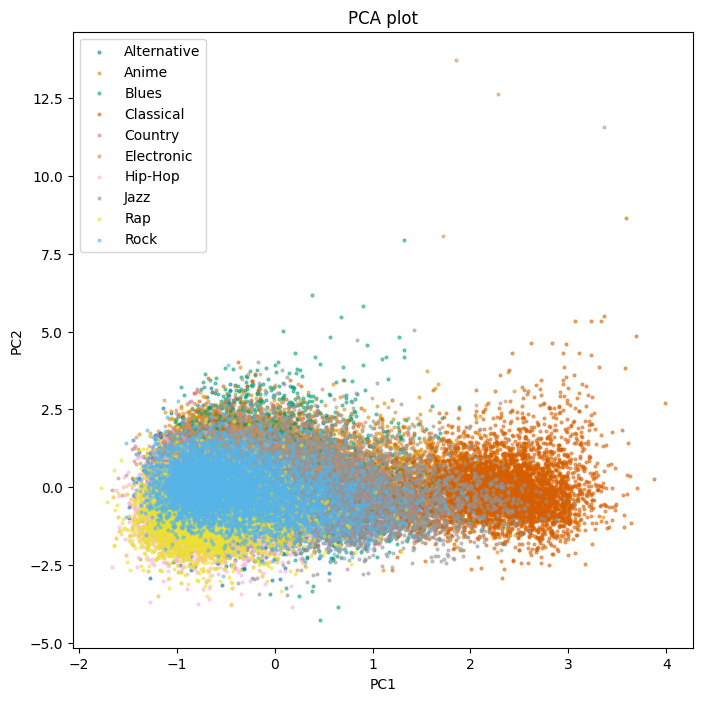

In [54]:
unique_categories = Y.cat.categories
n_categories = len(unique_categories)
colors = sns.color_palette('colorblind', n_categories)

# Create a scatter plot with color-coded data points
plt.figure(figsize=(8,8))
for i, category in enumerate(unique_categories):
    category_mask = (Y == category)
    plt.scatter(music_pca[category_mask, 0], music_pca[category_mask, 1], 
                color=colors[i], alpha=0.5, label=category, s = 4)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot')
plt.legend()
plt.show()

In [55]:
# 2D solution
music_pca_mdl = PCA(n_components=2, whiten=True)
music_pca_mdl.fit(X)
print("Eigenvalues: ", music_pca_mdl.explained_variance_)
music_pca_4d = music_pca_mdl.transform(X)

Eigenvalues:  [3.70640416 1.34738517]


### t-SNE

how to justify the perplexity?

In [56]:
music_tsne = TSNE(n_components=2, perplexity=25, n_jobs=-1).fit_transform(X)
music_tsne.shape

(50000, 2)

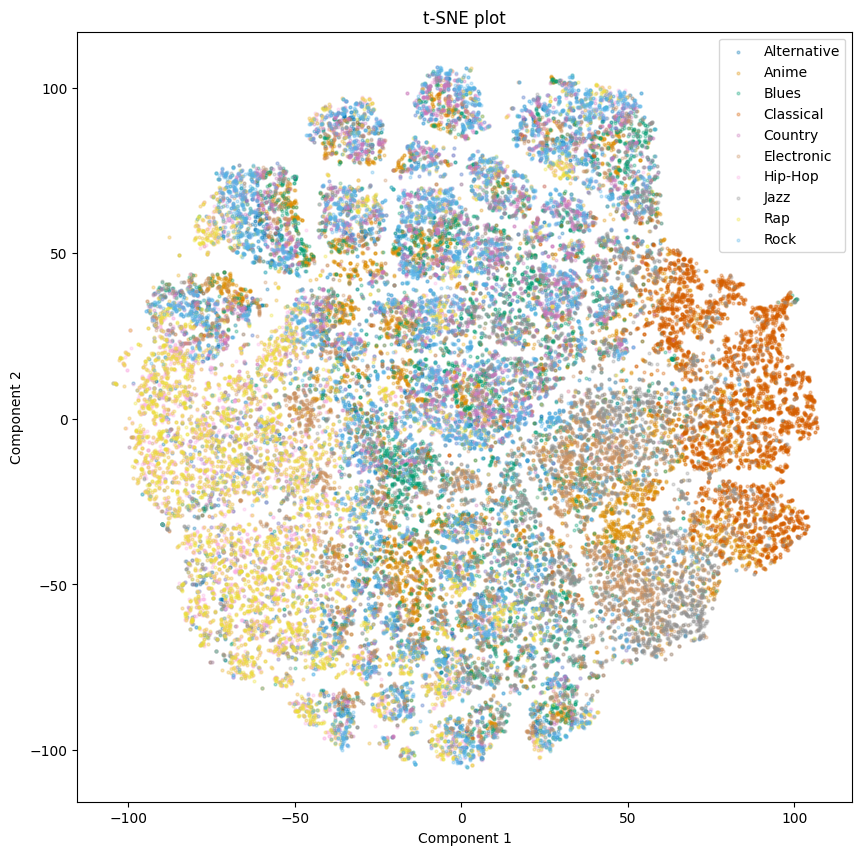

In [57]:
unique_categories = Y.cat.categories
n_categories = len(unique_categories)
colors = sns.color_palette('colorblind', n_categories)

# Create a scatter plot with color-coded data points
plt.figure(figsize=(10, 10))
for i, category in enumerate(unique_categories):
    category_mask = (Y == category)
    plt.scatter(music_tsne[category_mask, 0], music_tsne[category_mask, 1], 
                color=colors[i], alpha=0.3, label=category, s = 4)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE plot')
plt.legend()
plt.show()

## Training

### Split train set and test set

In [58]:
df = pd.concat([X, Y], axis=1)

# create empty dataframes to hold the train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# loop through each category
for category in Y.unique():
    
    # subset the data for this category
    category_data = df[df['music_genre'] == category]
    
    # split the category data into train and test sets
    category_train, category_test = model_selection.train_test_split(category_data, test_size=500, random_state=42)
    
    # append the train and test data to the corresponding dataframes
    train_data = pd.concat([train_data, category_train])
    test_data = pd.concat([test_data, category_test])


# separate the train and test data back into X and Y dataframes
x_train = train_data.drop('music_genre', axis=1)
y_train = train_data['music_genre']
x_test = test_data.drop('music_genre', axis=1)
y_test = test_data['music_genre']
print(len(x_test))
print(len(x_train))

print(len(train_data[train_data['music_genre'] == 'Electronic']))
print(len(train_data[train_data['music_genre'] == 'Anime']))


5000
45000
4500
4500


In [59]:
# for PCA data:

data = pd.DataFrame(data=music_pca, columns=['tsne_1', 'tsne_2'])
data['label'] = Y

# create empty dataframes to hold the train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# loop through each category
for category in Y.unique():
    
    # subset the data for this category
    category_data = df[df['music_genre'] == category]
    
    # split the category data into train and test sets
    category_train, category_test = model_selection.train_test_split(category_data, test_size=500, random_state=42)
    
    # append the train and test data to the corresponding dataframes
    train_data = pd.concat([train_data, category_train])
    test_data = pd.concat([test_data, category_test])

# separate the train and test data back into X and Y dataframes
x_train_pca = train_data.drop('music_genre', axis=1)
y_train_pca = train_data['music_genre']
x_test_pca = test_data.drop('music_genre', axis=1)
y_test_pca = test_data['music_genre']


In [60]:
# for tsne data:
data = pd.DataFrame(data=music_tsne, columns=['tsne_1', 'tsne_2'])
data['label'] = Y

# create empty dataframes to hold the train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# loop through each category
for category in Y.unique():
    
    # subset the data for this category
    category_data = df[df['music_genre'] == category]
    
    # split the category data into train and test sets
    category_train, category_test = model_selection.train_test_split(category_data, test_size=500, random_state=42)
    
    # append the train and test data to the corresponding dataframes
    train_data = pd.concat([train_data, category_train])
    test_data = pd.concat([test_data, category_test])

# separate the train and test data back into X and Y dataframes
x_train_tsne = train_data.drop('music_genre', axis=1)
y_train_tsne = train_data['music_genre']
x_test_tsne = test_data.drop('music_genre', axis=1)
y_test_tsne = test_data['music_genre']

### Logistic Regression

In [61]:
from sklearn.metrics import classification_report

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Alternative       0.34      0.26      0.29       500
       Anime       0.60      0.62      0.61       500
       Blues       0.53      0.48      0.50       500
   Classical       0.76      0.81      0.78       500
     Country       0.47      0.56      0.51       500
  Electronic       0.58      0.56      0.57       500
     Hip-Hop       0.46      0.48      0.47       500
        Jazz       0.51      0.46      0.49       500
         Rap       0.42      0.34      0.38       500
        Rock       0.50      0.66      0.57       500

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



c:\Users\hp\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
from sklearn.metrics import classification_report
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf.fit(x_train_pca, y_train_pca)
y_pred = clf.predict(x_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Alternative       0.34      0.26      0.29       500
       Anime       0.60      0.62      0.61       500
       Blues       0.53      0.48      0.50       500
   Classical       0.76      0.81      0.78       500
     Country       0.47      0.56      0.51       500
  Electronic       0.58      0.56      0.57       500
     Hip-Hop       0.46      0.48      0.47       500
        Jazz       0.51      0.46      0.49       500
         Rap       0.42      0.34      0.38       500
        Rock       0.50      0.66      0.57       500

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000



c:\Users\hp\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Tree

In [63]:
tree_clf = tree.DecisionTreeClassifier(criterion='gini')
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)
y_proba = tree_clf.predict_proba(x_test)
auc = metrics.roc_auc_score(y_test, y_proba, multi_class='ovr')

# print("Accuracy:", accuracy)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

AUC: 0.6851220888888889
              precision    recall  f1-score   support

 Alternative       0.26      0.27      0.27       500
       Anime       0.68      0.66      0.67       500
       Blues       0.44      0.46      0.45       500
   Classical       0.74      0.77      0.75       500
     Country       0.45      0.44      0.44       500
  Electronic       0.45      0.43      0.44       500
     Hip-Hop       0.27      0.30      0.29       500
        Jazz       0.36      0.34      0.35       500
         Rap       0.23      0.22      0.22       500
        Rock       0.38      0.37      0.38       500

    accuracy                           0.43      5000
   macro avg       0.43      0.43      0.43      5000
weighted avg       0.43      0.43      0.43      5000



### Random Forest

In [64]:
# data that has not performed dimension reduction

from sklearn.preprocessing import label_binarize
r_forest = ensemble.RandomForestClassifier(n_estimators = 200, max_samples = 1.0, max_features = 0.2, bootstrap = True, criterion='gini')
r_forest.fit(x_train, y_train)
y_pred = r_forest.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)

y_proba = r_forest.predict_proba(x_test)
auc = metrics.roc_auc_score(y_test, y_proba, multi_class='ovr')

print("Accuracy:", accuracy)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

Accuracy: 0.5492
AUC: 0.9154890666666666
              precision    recall  f1-score   support

 Alternative       0.38      0.31      0.34       500
       Anime       0.80      0.78      0.79       500
       Blues       0.63      0.57      0.60       500
   Classical       0.84      0.87      0.85       500
     Country       0.59      0.57      0.58       500
  Electronic       0.64      0.60      0.62       500
     Hip-Hop       0.34      0.36      0.35       500
        Jazz       0.55      0.54      0.55       500
         Rap       0.31      0.30      0.30       500
        Rock       0.44      0.59      0.50       500

    accuracy                           0.55      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.55      0.55      0.55      5000



In [64]:
# PCA + random forest

r_forest = ensemble.RandomForestClassifier(n_estimators = 200, max_samples = 1.0, max_features = 0.2, bootstrap = True, criterion='gini')
r_forest.fit(x_train_pca, y_train_pca)
y_pred = r_forest.predict(x_test_pca)
accuracy = metrics.accuracy_score(y_test_pca, y_pred)

y_proba = r_forest.predict_proba(x_test_pca)
auc = metrics.roc_auc_score(y_test_pca, y_proba, multi_class='ovr')

print("Accuracy:", accuracy)
print("AUC:", auc)
print(classification_report(y_test_pca, y_pred))

Accuracy: 0.5474
AUC: 0.914888288888889
              precision    recall  f1-score   support

 Alternative       0.40      0.33      0.36       500
       Anime       0.79      0.78      0.78       500
       Blues       0.64      0.59      0.62       500
   Classical       0.83      0.87      0.85       500
     Country       0.60      0.57      0.58       500
  Electronic       0.64      0.60      0.62       500
     Hip-Hop       0.31      0.33      0.32       500
        Jazz       0.55      0.53      0.54       500
         Rap       0.28      0.27      0.28       500
        Rock       0.44      0.61      0.52       500

    accuracy                           0.55      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.55      0.55      0.55      5000



In [74]:
# t-SNE + random forest
r_forest = ensemble.RandomForestClassifier(n_estimators = 200, max_samples = 1.0, max_features = 0.2, bootstrap = True, criterion='gini')
r_forest.fit(x_train_tsne, y_train_tsne)
y_pred = r_forest.predict(x_test_tsne)
accuracy = metrics.accuracy_score(y_test_tsne, y_pred)

y_proba = r_forest.predict_proba(x_test_tsne)
auc = metrics.roc_auc_score(y_test_tsne, y_proba, multi_class='ovr')

print("Accuracy:", accuracy)
print("AUC:", auc)
print(classification_report(y_test_tsne, y_pred))

Accuracy: 0.5378
AUC: 0.9109277999999998
              precision    recall  f1-score   support

 Alternative       0.36      0.31      0.34       500
       Anime       0.77      0.78      0.78       500
       Blues       0.62      0.57      0.59       500
   Classical       0.81      0.86      0.83       500
     Country       0.58      0.56      0.57       500
  Electronic       0.63      0.56      0.59       500
     Hip-Hop       0.32      0.34      0.33       500
        Jazz       0.54      0.50      0.52       500
         Rap       0.30      0.30      0.30       500
        Rock       0.45      0.60      0.51       500

    accuracy                           0.54      5000
   macro avg       0.54      0.54      0.54      5000
weighted avg       0.54      0.54      0.54      5000



### Adaboost

In [43]:
bdt = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=10), algorithm="SAMME", n_estimators=200, learning_rate=0.01)
bdt.fit(x_train, y_train)
Y_pred_proba = bdt.predict_proba(x_test)
auc_adaboost = metrics.roc_auc_score(y_test, Y_pred_proba, multi_class = 'ovr')
print('{:67s}{:.5f}'.format('AUC of adaboost with all predictors is: ', auc_adaboost))

AUC of adaboost with all predictors is:                            0.92130


In [42]:
bdt = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=10), algorithm="SAMME", n_estimators=300, learning_rate=0.01)
bdt.fit(x_train, y_train)
Y_pred_proba_auc = bdt.predict_proba(x_test)
auc_adaboost = metrics.roc_auc_score(y_test, Y_pred_proba_auc, multi_class = 'ovr')
print('{:67s}{:.5f}'.format('AUC of adaboost with all predictors is: ', auc_adaboost))

AUC of adaboost with all predictors is:                            0.92281


### Neural Netowrk

#### Feedforward Neural Network

In [71]:
torch.manual_seed(seed)
N = 4500  # num_samples_per_class
D = 25  # dimensions
C = 10  # num_classes
H = 20  # num_hidden_units

# Get our device in a variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-1
lambda_l2 = 1e-3 

In [72]:
x_train_tensor = torch.tensor(x_train.astype(np.float32).values)
x_test_tensor = torch.tensor(x_test.astype(np.float32).values)
y_train_code = y_train.cat.codes
y_test_code = y_test.cat.codes
y_train_tensor = torch.tensor(y_train_code.astype(np.int64).values)
y_test_tensor = torch.tensor(y_test_code.astype(np.int64).values)

In [73]:
# model with no activation function and 1 hidden layer
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, H),
    nn.Linear(H, C)
)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) 

for t in range(1000):
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_train_tensor == predicted).sum().float() / len(y_train_tensor)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[EPOCH]: 999, [LOSS]: 1.261941, [ACCURACY]: 0.530


In [21]:
Y_pred = model(x_test_tensor)
y_pred_prob = softmax(Y_pred.detach().numpy(), axis=1)
y_pred_tensor = torch.from_numpy(y_pred_prob)
_, y_pred_label = torch.max(y_pred_tensor, 1)
print(y_pred_prob)
print(len(y_pred_label))

[[5.2337904e-02 1.2436355e-01 1.4281135e-02 ... 2.0055238e-02
  1.6413997e-03 5.0911462e-05]
 [2.9245013e-01 5.1792236e-03 5.4879449e-02 ... 8.8753134e-02
  3.3762645e-02 3.0897757e-01]
 [1.7842295e-02 5.0360233e-01 6.3115031e-02 ... 2.3327585e-02
  1.8694569e-05 5.0091848e-04]
 ...
 [1.5917414e-01 1.5351082e-04 1.7497336e-03 ... 2.2989547e-02
  3.2615528e-01 1.5553373e-01]
 [2.6131561e-01 4.0804986e-03 5.3125653e-02 ... 9.2780732e-02
  2.1626493e-01 1.1068876e-02]
 [7.7808581e-02 4.9068782e-05 1.2456788e-03 ... 6.4920927e-03
  4.1987270e-01 7.0815026e-03]]
5000


In [22]:
y_val = y_pred_label.detach().numpy()
auc_score = metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print(auc_score)

0.9025898666666666


In [ ]:
n_classes = y_test.shape[0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], Y_pred_proba_auc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='micro')

# Plot ROC curve for each class
plt.figure()
lw = 2
colors = ['red', 'green', 'blue'] # change the colors as per the number of classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

In [27]:
# deep network model 
model_deep_network = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
print(model_deep_network)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_deep_network.parameters(), lr=learning_rate, weight_decay=lambda_l2) 

for t in range(1000):
    y_pred = model_deep_network(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_train_tensor == predicted).sum().float() / len(y_train_tensor)
    print("[EPOCH]: %i, [LOSS(RMSE)]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[EPOCH]: 999, [LOSS(RMSE)]: 1.216247, [ACCURACY]: 0.538


In [28]:
Y_pred = model_deep_network(x_test_tensor)
y_pred_prob = softmax(Y_pred.detach().numpy(), axis=1)
y_pred_tensor = torch.from_numpy(y_pred_prob)
_, y_pred_label = torch.max(y_pred_tensor, 1)
print(y_pred_prob)
print(len(y_pred_label))

[[2.4098532e-02 2.0736592e-01 5.9399601e-02 ... 6.2773235e-02
  6.8464564e-05 7.8205463e-05]
 [2.5332692e-01 2.4729993e-03 4.0639985e-02 ... 4.0609971e-02
  4.5151901e-02 3.8539082e-01]
 [1.7042266e-02 4.7673011e-01 7.0683114e-02 ... 3.9566107e-02
  2.7029391e-06 2.8612822e-05]
 ...
 [7.4879900e-02 1.4931965e-04 4.3536401e-03 ... 7.8183226e-03
  4.0184131e-01 1.3983506e-01]
 [9.4718076e-02 5.4992875e-04 1.1580037e-02 ... 3.1360254e-02
  2.9947957e-01 1.7408881e-02]
 [3.8005210e-02 5.5805267e-05 1.1241633e-03 ... 6.7992941e-03
  4.3737742e-01 1.1627917e-02]]
5000


In [29]:
y_val = y_pred_label.detach().numpy()
auc_score = metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
print(auc_score)

0.908600311111111


### Find most predictive one
I only did this for adaboost. 

In [ ]:
df = pd.concat([X, Y], axis=1)

# create empty dataframes to hold the train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# loop through each category
for category in Y.unique():
    
    # subset the data for this category
    category_data = df[df['music_genre'] == category]
    
    # split the category data into train and test sets
    category_train, category_test = model_selection.train_test_split(category_data, test_size=500, random_state=42)
    
    # append the train and test data to the corresponding dataframes
    train_data = pd.concat([train_data, category_train])
    test_data = pd.concat([test_data, category_test])


# separate the train and test data back into X and Y dataframes
x_train = train_data.drop('music_genre', axis=1)
y_train = train_data['music_genre']
x_test = test_data.drop('music_genre', axis=1)
y_test = test_data['music_genre']
print(len(x_test))
print(len(x_train))

print(len(train_data[train_data['music_genre'] == 'Electronic']))
print(len(train_data[train_data['music_genre'] == 'Anime']))


In [67]:
bdt = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=10), algorithm="SAMME", n_estimators=300, learning_rate=0.01)


predictors = {}
for i in range(len(x_train.columns)):
    x_train_new = x_train.drop(x_train.columns[i], axis = 1)
    x_test_new = x_test.drop(x_test.columns[i], axis = 1)   
    bdt.fit(x_train_new, y_train)
    Y_pred_proba = bdt.predict_proba(x_test_new)
    auc_adaboost = metrics.roc_auc_score(y_test, Y_pred_proba, multi_class = 'ovr')
    predictors[x_train.columns[i]] = auc_adaboost
       

from operator import itemgetter
for k, v in sorted(predictors.items(),key = itemgetter(1), reverse = True):
    print('{:63s}{:.8f}'.format('AUC of logistic regression model with {} dropped is: '.format(k), v))
   

AUC of logistic regression model with key_F# dropped is:       0.92271613
AUC of logistic regression model with key_G dropped is:        0.92258240
AUC of logistic regression model with key_A# dropped is:       0.92238991
AUC of logistic regression model with key_A dropped is:        0.92227387
AUC of logistic regression model with key_E dropped is:        0.92224356
AUC of logistic regression model with key_F dropped is:        0.92215533
AUC of logistic regression model with key_D# dropped is:       0.92213262
AUC of logistic regression model with key_B dropped is:        0.92210227
AUC of logistic regression model with liveness dropped is:     0.92206689
AUC of logistic regression model with key_C dropped is:        0.92201018
AUC of logistic regression model with key_G# dropped is:       0.92196427
AUC of logistic regression model with mode_Major dropped is:   0.92176333
AUC of logistic regression model with key_D dropped is:        0.92174671
AUC of logistic regression model with 